In [17]:
# Imports
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import networkx as nx
import matplotlib.pyplot as plt
import random
from node2vec import Node2Vec
import numpy as np

pd.set_option('display.max_columns', None)

## 1. Load the Data:

In [2]:
# Load the data
column_names = ["duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land", "wrong_fragment", "urgent",
                "hot", "num_failed_logins", "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root",
                "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login",
                "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
                "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
                "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate",
                "dst_host_serror_rate", "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"]

df = pd.read_csv('data/kddcup.data.gz', header=None, names=column_names, compression='gzip')
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,215,45076,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,162,4528,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,236,1228,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,233,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,normal.


## 2. Remove Outliers

For simplicity, we'll use the IQR method to detect and remove outliers for the numerical columns:



In [3]:
# Define a function to remove outliers using IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    df = df[~((df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR)))]
    return df

# List of numerical columns
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Remove outliers for each numerical column
for column in numerical_columns:
    df = remove_outliers(df, column)

In [4]:
df.shape

(2806165, 42)

Count how many NaN values there are overall in the dataset (All added in the remove outlier step):

In [5]:
df.isna().sum().sum()

0

Count how many rows have at leat one NaN value:

In [6]:
na_row_count = (df.isnull().sum(axis=1) > 0).sum()
print(na_row_count)

0


## 3. Normalization:

We'll use Min-Max scaling for normalization:

In [7]:
# Initialize the scaler
scaler = MinMaxScaler()

# Apply the scaler to the numerical columns
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

## 4. Convert to Graph:

Let's proceed with the optimal graph construction for the KDD Cup 1999 dataset. We'll use the NetworkX library for this purpose, as it's user-friendly and suitable for this demonstration.

##### Initialize an Empty Graph:

In [8]:
# Initialize an Empty Graph
G = nx.Graph()

##### Add Nodes and Edges:

We'll represent each unique connection as a node and add edges based on shared attributes. For simplicity, we'll use protocol_type as the attribute to determine edges.

In [9]:
# Add nodes to the graph with protocol_type as an attribute
for index, row in df.iterrows():
    G.add_node(index, protocol_type=row['protocol_type'])


In [10]:
# Create a mapping of protocol_type to indices
protocol_mapping = df.groupby('protocol_type').apply(lambda x: x.index.tolist()).to_dict()

# Add edges based on the condition
for protocol, indices in protocol_mapping.items():
    for i in range(len(indices) - 1):
        # Check if the next connection is within the time window
        if indices[i + 1] - indices[i] <= 2:
            G.add_edge(indices[i], indices[i + 1])


## 5. Basic Graph Statistics

Before visualizing, it's helpful to understand some basic statistics about the graph.

In [11]:
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Average degree: {sum(dict(G.degree()).values()) / G.number_of_nodes()}")

Number of nodes: 2806165
Number of edges: 2806154
Average degree: 1.999992160118881


## 6. Visualize a Subgraph

Visualizing the entire graph might not be feasible or informative. Instead, I can visualize a subgraph. One way to extract a subgraph is to focus on nodes with a high degree (many connections).

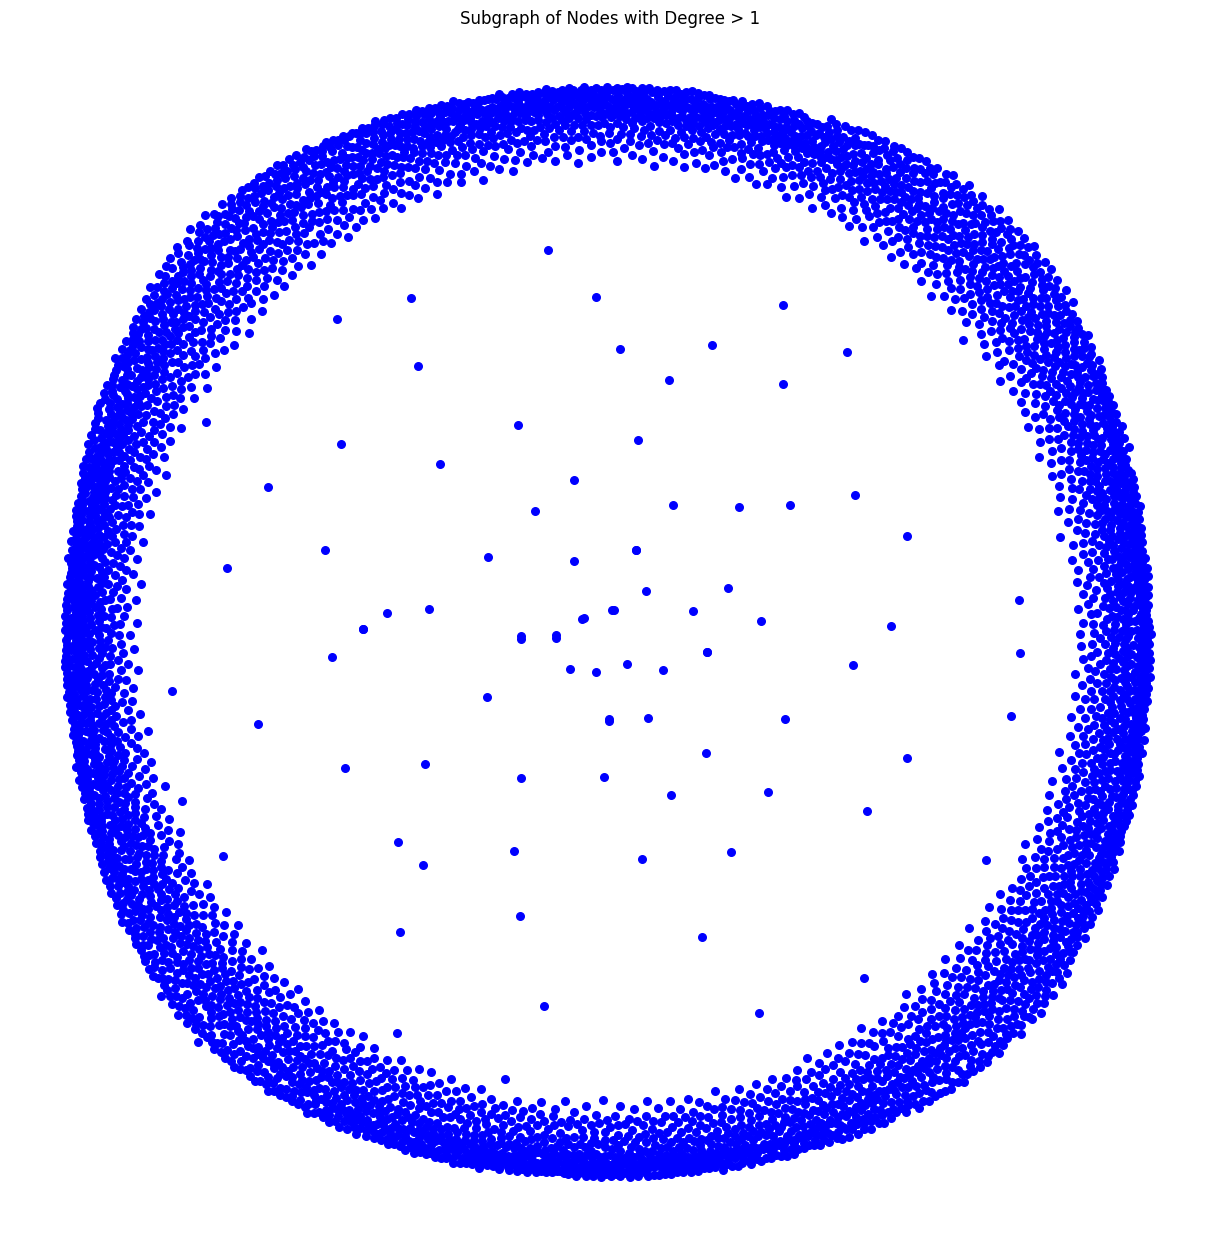

In [12]:
# Extract nodes with a degree higher than 1
higher_degree_nodes = [node for node, degree in dict(G.degree()).items() if degree > 1]

# Randomly sample a subset of these nodes, say 1000 nodes
sampled_nodes = random.sample(higher_degree_nodes, 5000)
subgraph = G.subgraph(sampled_nodes)

# Draw the subgraph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(subgraph, seed=42)  # Using a seed for reproducibility
nx.draw(subgraph, pos, with_labels=False, node_size=30, node_color='blue', edge_color='orange')
plt.title("Subgraph of Nodes with Degree > 1")
plt.show()

## 7. Degree Distribution:

Understanding the degree distribution can give insights into the network's structure.

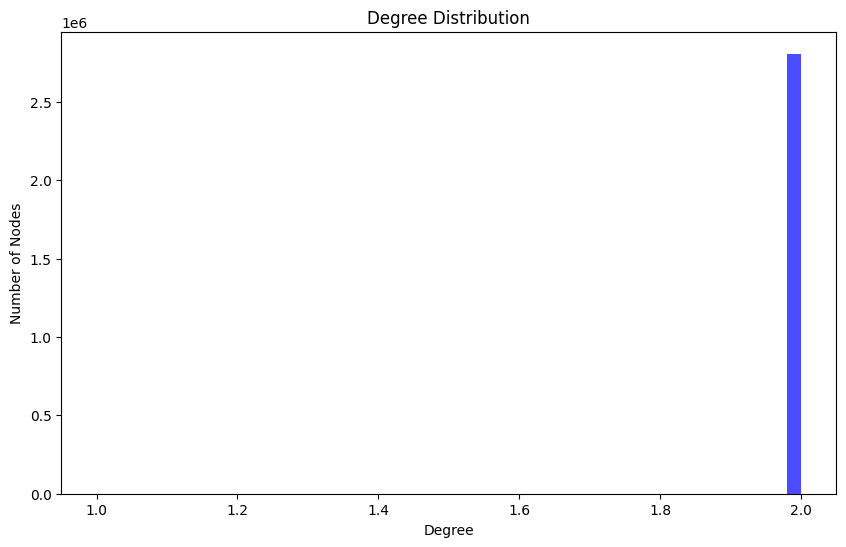

In [13]:
degrees = [G.degree(n) for n in G.nodes()]

plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=50, color='blue', alpha=0.7)
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Number of Nodes")
plt.show()

## 8. Simulating Dynamic Behavior

Given that the KDD Cup 1999 dataset is static, we need to simulate dynamic behavior. One way to do this is by dividing the graph into multiple time snapshots. For simplicity, let's divide the graph into three snapshots.



In [14]:
# Split the nodes into three sets
nodes_set_1 = sampled_nodes[:int(len(sampled_nodes)/3)]
nodes_set_2 = sampled_nodes[int(len(sampled_nodes)/3):int(2*len(sampled_nodes)/3)]
nodes_set_3 = sampled_nodes[int(2*len(sampled_nodes)/3):]

# Create subgraphs for each set
subgraph_1 = G.subgraph(nodes_set_1)
subgraph_2 = G.subgraph(nodes_set_2)
subgraph_3 = G.subgraph(nodes_set_3)

## 9. Generate Embeddings for Each Graph Snapshot

For each snapshot of your dynamic graph, you'll generate embeddings using node2vec.

In [16]:
def generate_embeddings(graph):
    # Precompute probabilities and generate walks
    node2vec = Node2Vec(graph, dimensions=64, walk_length=30, num_walks=200, workers=4)

    # Embed nodes
    model = node2vec.fit(window=10, min_count=1, batch_words=4)

    return model

# Generate embeddings for each subgraph
embeddings_1 = generate_embeddings(subgraph_1)
embeddings_2 = generate_embeddings(subgraph_2)
embeddings_3 = generate_embeddings(subgraph_3)

Computing transition probabilities:   0%|          | 0/1666 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 50/50 [00:00<00:00, 138.02it/s]


Computing transition probabilities:   0%|          | 0/1667 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 131.10it/s]


Computing transition probabilities:   0%|          | 0/1667 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 192.38it/s]


In [21]:
# Find common nodes across all subgraphs
common_nodes = set(subgraph_1.nodes()).intersection(subgraph_2.nodes()).intersection(subgraph_3.nodes())

def concatenate_embeddings(node, embeddings_list):
    return np.concatenate([emb.wv[node] for emb in embeddings_list if node in emb.wv])

concatenated_embeddings = {node: concatenate_embeddings(node, [embeddings_1, embeddings_2, embeddings_3]) for node in common_nodes}

In [23]:
# Find common nodes across all subgraphs
common_nodes = set(subgraph_1.nodes()).intersection(subgraph_2.nodes()).intersection(subgraph_3.nodes())

def compute_delta_embeddings(node, embeddings_list):
    # Ensure the node exists in all embeddings before computing delta
    if all(node in emb.wv for emb in embeddings_list):
        return embeddings_list[1].wv[node] - embeddings_list[0].wv[node]
    else:
        return None

delta_embeddings = {node: compute_delta_embeddings(node, [embeddings_1, embeddings_2]) for node in common_nodes}
# Filter out None values
delta_embeddings = {node: delta for node, delta in delta_embeddings.items() if delta is not None}

In [30]:
# Extract nodes and their embeddings
nodes = list(delta_embeddings.keys())
embeddings_matrix = np.array([delta_embeddings[node] for node in nodes])

In [33]:
common_nodes = set(subgraph_1.nodes()).intersection(set(subgraph_2.nodes())).intersection(set(subgraph_3.nodes()))
print(len(common_nodes))


0


In [35]:
overlap_12 = set(subgraph_1.nodes()).intersection(set(subgraph_2.nodes()))
overlap_23 = set(subgraph_2.nodes()).intersection(set(subgraph_3.nodes()))
overlap_13 = set(subgraph_1.nodes()).intersection(set(subgraph_3.nodes()))

print("Overlap between subgraph_1 and subgraph_2:", len(overlap_12))
print("Overlap between subgraph_2 and subgraph_3:", len(overlap_23))
print("Overlap between subgraph_1 and subgraph_3:", len(overlap_13))


Overlap between subgraph_1 and subgraph_2: 0
Overlap between subgraph_2 and subgraph_3: 0
Overlap between subgraph_1 and subgraph_3: 0


In [29]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(contamination=0.05)  # contamination parameter can be tuned
clf.fit(embeddings_matrix)

# Predict anomalies
predictions = clf.predict(embeddings_matrix)


ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by IsolationForest.